[4.924676895141602, 6.581079483032227, 20.922203063964844, 6.978376865386963, 12.196871757507324, 7.384722709655762, 13.170844078063965, 7.168610572814941, 11.786433219909668, 11.057579040527344, 10.754589080810547, 9.497156143188477, 13.799635887145996, 12.203316688537598, 10.534687042236328, 7.146463394165039, 13.045473098754883, 7.476703643798828, 9.924163818359375, 19.29234504699707, 4.108016490936279, 22.237014770507812, 3.4624767303466797, 14.537367820739746, 3.3936266899108887, 5.079035758972168, 9.940997123718262, 8.773470878601074, 6.777005672454834, 10.167704582214355, 7.236538410186768, 8.593171119689941, 7.9749836921691895, 6.854467391967773, 16.220279693603516, -0.20374998450279236, 15.680188179016113, 13.95114517211914, 18.50083351135254, 7.63372278213501, 15.37598705291748, 10.73198413848877]
('ica', 0, 6.238347322458313, 0.623696503467043, 1.0211344315950401e-05, 0.3268637843625771)


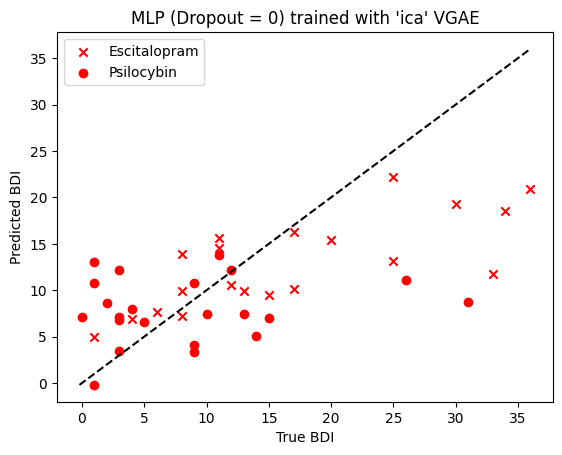

[1.5969550609588623, 20.103885650634766, 22.53474235534668, 3.944988250732422, 6.395744323730469, 13.76101016998291, 19.80685806274414, 8.303486824035645, 9.196396827697754, 12.038030624389648, 11.535167694091797, 11.829399108886719, 13.753257751464844, 11.97883415222168, 10.154806137084961, 7.735570907592773, 14.44566822052002, 8.909004211425781, 8.610624313354492, 17.7076473236084, 13.487272262573242, 18.311071395874023, 2.836437940597534, 9.84939193725586, 0.6935193538665771, 4.251340866088867, 11.153009414672852, 11.373825073242188, 4.211111545562744, 21.079641342163086, 11.916545867919922, 8.271791458129883, 4.6090087890625, 9.450706481933594, 13.270675659179688, 0.04171169549226761, 16.442760467529297, 13.647189140319824, 26.695154190063477, 19.141916275024414, 15.419182777404785, 12.804720878601074]
('fine_tune', 0, 6.293047811126425, 0.555047812046864, 0.00013620278329933662, 0.2985880562793717)


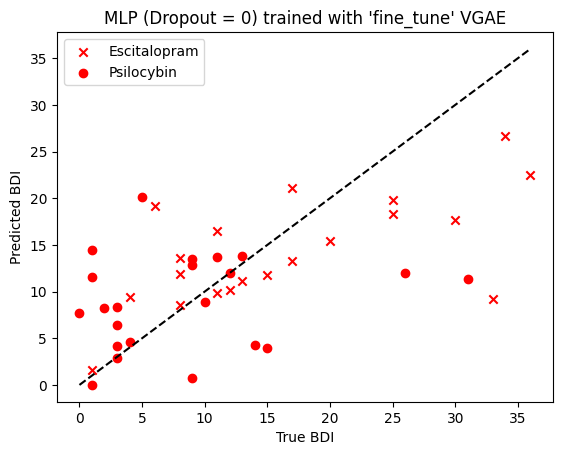

[0.5157283544540405, 16.34596824645996, 17.792232513427734, 13.971657752990723, 12.245346069335938, 5.471512317657471, 18.555953979492188, 3.773615837097168, 8.784402847290039, 12.973736763000488, 12.948145866394043, 12.042877197265625, 15.410608291625977, 13.39571762084961, 12.10647201538086, 6.941220283508301, 16.928613662719727, 8.770957946777344, 16.253816604614258, 25.48231315612793, 12.446264266967773, 19.816268920898438, 2.7377676963806152, 9.946208953857422, 2.9649875164031982, 8.766851425170898, 10.902759552001953, 8.976597785949707, 3.9116344451904297, 17.35564613342285, 13.098652839660645, 4.328344345092773, 10.331717491149902, 10.80711841583252, 14.045802116394043, -0.32211506366729736, 19.91209602355957, 13.636617660522461, 29.926471710205078, 14.248312950134277, 22.10401725769043, 6.980928421020508]
('schaefer', 0, 6.010143915812175, 0.5634142832714073, 0.00010238208129401657, 0.31100448210288223)


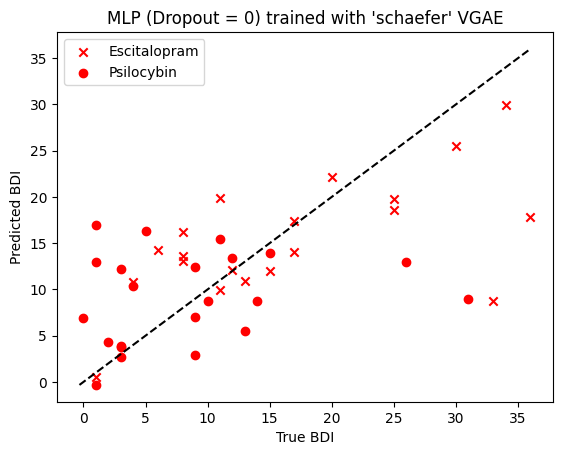

[3.06697678565979, 3.955904722213745, 21.2448673248291, 10.635185241699219, 10.641178131103516, 0.2655312120914459, 14.192056655883789, 10.908791542053223, 11.767768859863281, 9.708647727966309, 7.0102715492248535, 17.133441925048828, 13.454146385192871, 17.860061645507812, 17.523101806640625, 1.5237637758255005, 19.973846435546875, 5.163325309753418, 17.45368003845215, 17.72820281982422, 12.553114891052246, 16.602909088134766, 3.336988925933838, 7.446457862854004, 9.09211254119873, 6.570136070251465, 13.573956489562988, 4.864236831665039, 4.8545331954956055, 14.689934730529785, 16.862829208374023, 0.44721683859825134, 10.004388809204102, 9.552486419677734, 28.291433334350586, 2.747689723968506, 15.752801895141602, 17.598777770996094, 29.368345260620117, 0.9350839853286743, 18.150556564331055, 5.617597579956055]
('aal', 0, 6.819438298543294, 0.4954480258155224, 0.0008495606232370601, 0.19187146503682861)


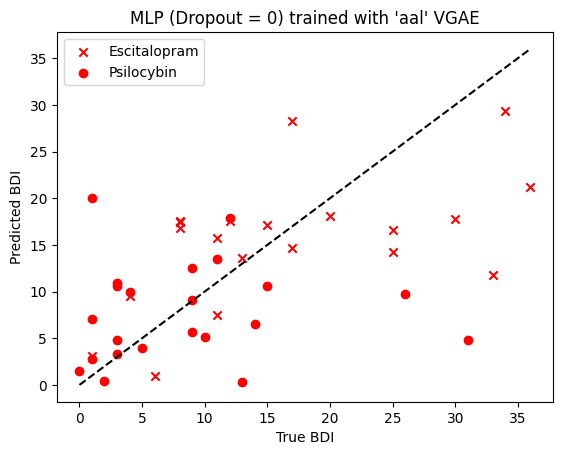

In [3]:
import sys
sys.path.append('../')

from models import LatentMLP, VGAE
from utils import BrainGraphDataset, project_root, get_data_labels
import torch
import torch.optim as optim
import os
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import copy
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

root = project_root()

categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

annotations = 'annotations.csv'

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataroot = 'fc_matrices/psilo_ica_100_before/'
psilo_ica_before_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=data_labels, setting='lz')

dataroot = 'fc_matrices/psilo_schaefer_before/'
psilo_schaefer_before_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=data_labels, setting='lz')

dataroot = 'fc_matrices/psilo_aal_before/'
psilo_aal_before_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=data_labels, setting='lz')


configs = [
#     (psilo_ica_before_dataset, 'vgae_nf_ica_32_8.pt', 'ica'),
#     (psilo_ica_before_dataset, 'vgae_nf_fine_tune.pt', 'fine_tune'),
    (psilo_schaefer_before_dataset, 'vgae_nf_schaefer_32_8.pt', 'schaefer'),
#     (psilo_aal_before_dataset, 'vgae_nf_aal_32_8.pt', 'aal'),
]

results = []

for config in configs:
    # instantiate the VGAE model
    hidden_dim = 64
    latent_dim = 64
    output_dim = 1
    input_dim = 6670 if 'aal' in config[1] else 4950
    lr = 0.001
    batch_size = 8

    num_rois = 116 if 'aal' in config[1] else 100
    vgae = VGAE(1, 1, num_rois, 32, 8, device, dropout=0, l2_strength=0.001).to(device)
    # load the trained VGAE weights
    # Convert the model to the device
    vgae.to(device)

    # define the optimizer and the loss function
    criterion = nn.L1Loss(reduction='sum')

    # Convert the model to the device
    vgae.to(device)

    dataset = config[0]

    # Assuming you have your dataset defined as 'dataset'
    num_folds = 5  # Specify the number of folds
    batch_size = 8  # Specify your desired batch size
    random_seed = 42  # Specify the random seed

    # Create indices for k-fold cross-validation with seeded random number generator
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

    # Create empty lists to store train and validation loaders
    train_loaders = []
    val_loaders = []

    for train_index, val_index in kf.split(dataset):
        # Split dataset into train and validation sets for the current fold
        train_set = torch.utils.data.Subset(dataset, train_index)
        val_set = torch.utils.data.Subset(dataset, val_index)

        # Define the dataloaders for the current fold
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=len(val_index), shuffle=False)

        # Append the loaders to the respective lists
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)

    # dropout_list = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    dropout_list = [0]
    
    best_r2 = -float('inf')
    best_result = None
    
    for dropout in dropout_list:
          
        val_label = []
        val_output = []
        val_base = []
        
        with torch.no_grad():
            for t, train_loader in enumerate(train_loaders):
                val_loader = val_loaders[t]
                # instantiate the LatentMLP model

                model = LatentMLP(latent_dim, hidden_dim, output_dim, dropout=0)
                # Convert the MLP to the device
                model.to(device)


                model.load_state_dict(torch.load(os.path.join(root, f'mlp_weights/vgae_model_weight_{config[2]}_{dropout}_{t}.pt'), 
                                               map_location=device))
                vgae.load_state_dict(torch.load(os.path.join(root, f'mlp_weights/vgae_vgae_weight_{config[2]}_{dropout}_{t}.pt'), 
                                                map_location=device))

                model.eval()
                vgae.eval()

                src, dest = vgae.edge_index

                for batch_idx, ((graph, lz, baseline_bdi), label) in enumerate(val_loader):
                    graph = graph.to(device)  # move data to device
                    lz = lz.to(device)
                    label = label.to(device)

                    rcn_lz, rcn_edges, z, _, _ = vgae(lz, graph)
                    graph = graph[:, src, dest]

                    output_bdi = model(z.view(z.shape[0], -1), baseline_bdi)

                    val_label.extend(label.flatten().tolist())
                    val_output.extend(output_bdi.flatten().tolist())
                    val_base.extend(baseline_bdi[:, 0])

        print(val_output)
#         print(val_output)
        corr, p = pearsonr(val_label, val_output)
        r2 = r2_score(val_label, val_output)
        mae = mean_absolute_error(val_label, val_output)

        results.append((config[2], dropout, mae, corr, p, r2))
        
        if dropout == 0:
            best_result = (config[2], dropout, val_label, val_output, val_base)
            print(results[-1])
            best_r2 = r2
            
    
    con, dropout, true, pred, drug = best_result
    
    psilo_loss = 0.
    psilo_no_out_loss = 0.
    psilo_count = 0
    
    esc_loss = 0.
    esc_count = 0
    
    for t, p, d in zip(true, pred, drug):
        marker = 'x' if d == -1 else 'o'
        plt.scatter(t, p, color='red', marker=marker)
        
#     for t, p, d in zip(true, pred, drug):
        
#         if d == -1:
#             esc_loss += abs(t - p)
#             esc_count += 1
#         else:
#             psilo_loss += abs(t - p)
#             if t < 20:
#                 psilo_no_out_loss += abs(t - p)
#                 psilo_count += 1
            
#     print(psilo_loss / psilo_count)
#     print(psilo_no_out_loss / (psilo_count - 2))
#     print(esc_loss / esc_count)
    
    min_val = min(min(true), min(pred))
    max_val = max(max(true), max(pred))
    
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    plt.title(f'MLP (Dropout = {dropout}) trained with \'{con}\' VGAE')
    plt.xlabel('True BDI')
    plt.ylabel('Predicted BDI')
    plt.legend(['Escitalopram', 'Psilocybin'])
    plt.savefig(f'vgae_{con}_{dropout}_kfold.png', bbox_inches='tight')
    plt.show()
        
filename = "full-vgae-feature-k-fold-results.csv"

import csv
# Writing the results to the CSV file
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Config', 'Dropout', 'MAE', 'Corr', 'P', 'R2'])  # Writing the header
    writer.writerows(results)  # Writing the data rows        